# Modelowania i walidacja
### Stellar Classification Dataset - SDSS17
https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS\
alpha = Right Ascension angle (at J2000 epoch)\
delta = Declination angle (at J2000 epoch)\
u = Ultraviolet filter in the photometric system\
g = Green filter in the photometric system\
r = Red filter in the photometric system\
i = Near Infrared filter in the photometric system\
z = Infrared filter in the photometric system\
run_ID = Run Number used to identify the specific scan\
rereun_ID = Rerun Number to specify how the image was processed\
cam_col = Camera column to identify the scanline within the run\
field_ID = Field number to identify each field\
spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)\
class = object class (galaxy, star or quasar object)\
redshift = redshift value based on the increase in wavelength\
plate = plate ID, identifies each plate in SDSS\
MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken\
fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation\

#### Citation
fedesoriano. (January 2022). Stellar Classification Dataset - SDSS17. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/stellar-classification-dataset-sdss17.

Acknowledgements
The data released by the SDSS is under public domain. Its taken from the current data release RD17.

More information about the license: http://www.sdss.org/science/image-gallery/

#### Wczytanie bibliotek

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn 

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from scipy.stats import poisson, expon, uniform, randint, norm, gamma

import warnings
warnings.filterwarnings('ignore')
np.random.seed = 42

In [52]:
# Kod z https://stackoverflow.com/a/49199019 generujący zawartość requiments.txt
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]
        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        poorly_named_packages = {"PIL": "Pillow", "sklearn": "scikit-learn", "skopt":"scikit-optimize"}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name
imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
for i in range(len(requirements)):
    print(f'{requirements[i][0]}=={requirements[i][1]}')
print('scikit-optimize==0.10.1')

imblearn==0.0
matplotlib==3.7.2
numpy==1.24.3
pandas==2.0.3
scikit-learn==1.2.2
seaborn==0.12.2
xgboost==2.0.3
scikit-optimize==0.10.1


#### Używane funkcje

In [3]:
def handle_outliers(df):
    columns_to_be_checked = ['r', 'u', 'i', 'z', 'g']
    
    df = df[df['u'] > 0]

    for i in range(len(columns_to_be_checked)):
        column = df[columns_to_be_checked[i]]
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)

        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = (column < lower_bound) | (column > upper_bound)

        outliers_count = outliers.sum()

        outliers_percentage = outliers.mean() * 100
        
        # Zastąpienie outlierów wartościami równymi Q1 - 1.5 * IQR lub Q3 + 1.5 * IQR
        df.loc[outliers, columns_to_be_checked[i]] = np.where(column[outliers] < lower_bound, lower_bound, upper_bound)

        print("Ilość outlierów dla kolumny ", columns_to_be_checked[i], ": ", outliers_count)
        print("Procentowy udział outlierów dla kolumny ", columns_to_be_checked[i], ": ", outliers_percentage)

    return df

def modify_data(df, do_handle_outliers=False):
    
    if do_handle_outliers:
        df = handle_outliers(df)
    df = df[df['u'] > 0]
    
    df = df.loc[:, df.columns != 'rerun_ID']
    df = df.loc[:, df.columns != 'obj_ID']
    df = df.loc[:, df.columns != 'plate']
    
    df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)

    # Normalizacja
    columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
    df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

    # Standaryzacja
    columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z']
    df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])

    # Usuwanie kolumn
    df = df.drop(['MJD'], axis = 1)
    df = df.drop(['r', 'i', 'z'], axis = 1)

    # Odrzucenie cech na podstawie interpretacji ich znaczenia
    df = df.drop(['spec_obj_ID'], axis = 1) # numer obiektu
    df = df.drop(['alpha'], axis = 1) # współrzędne astronomiczne
    df = df.drop(['delta'], axis = 1) # współrzędne astronomiczne
    df = df.drop(['field_ID'], axis = 1) # numer pola ze zdjęcia (fragment zdjęcia)
    df = df.drop(['cam_col'], axis = 1) # numer kolumny ze zdjęcia (fragment zdjęcia)
    df = df.drop(['run_ID'], axis = 1) # numer zdjęcia
    df = df.drop(['fiber_ID'], axis = 1) # numer włókna, które skierowało światło na płaszczyznę ogniskową
    
    return df

def accuracy_fun(test_target, test_predictions):
    # Dokładność całkowita
    accuracy = accuracy_score(test_target, test_predictions)
    print("Dokładność całkowita (Accuracy):", accuracy)
    return accuracy

def raport(test_target, test_predictions):
    print("\nRaport klasyfikacji:")
    print(classification_report(test_target, test_predictions))

def matrix_confusion(test_target, test_predictions):
    print("\nConfusion matrix:")
    print(confusion_matrix(test_target, test_predictions))


def auc_gini(lb, test_target_bin, proba_predictions, test_target, model):
    auc_scores = []
    for i in range(len(lb.classes_)):
        auc_score = roc_auc_score(test_target_bin[:, i], proba_predictions[:, i])
        auc_scores.append(auc_score)
        print(f"AUC dla klasy {lb.classes_[i]}: {auc_score}")
        print(f"Gini dla klasy {lb.classes_[i]}: {2 * auc_score - 1}")
        print(" ")
        
        fpr, tpr, _ = roc_curve(test_target == model.classes_[i], proba_predictions[:, i])
        plt.plot(fpr, tpr, label=f'{model.classes_[i]} (AUC = {auc_score:.2f})')
    
    # Średni AUC
    mean_auc = np.mean(auc_scores)
    print("Średni AUC:", mean_auc)
    
    gini_coefficient = 2 * mean_auc - 1
    print("Gini coefficient:", gini_coefficient)
    return auc_scores, mean_auc, gini_coefficient

def evaluate_model(model, train_df, test_df, wersja=1):
    
    # Dane
    train_target = train_df['class']
    train_data = train_df.drop('class', axis=1)
    test_target = test_df['class']
    test_data = test_df.drop('class', axis=1)
    
    if wersja == 1:

        # Trenowanie modelu
        model.fit(train_data, train_target)

        # Predykcja klas dla danych testowych
        test_predictions = model.predict(test_data)

        # Accuracy
        accuracy = accuracy_fun(test_target, test_predictions)

        # Raport klasyfikacji
        raport(test_target, test_predictions)

        # Macierz pomyłek
        matrix_confusion(test_target, test_predictions)

        proba_predictions = model.predict_proba(test_data)

        # Konwersja etykiet klas na formę binarną dla każdej klasy
        lb = LabelBinarizer()
        lb.fit(train_target)
        test_target_bin = lb.transform(test_target)

        # Obliczenie AUC dla każdej klasy
        auc_gini(lb, test_target_bin, proba_predictions, test_target, model)
    
    if wersja == 2:

        # Zakodowanie etykiet klas jako liczby
        label_encoder = LabelEncoder()
        train_target_encoded = label_encoder.fit_transform(train_target)
        test_target_encoded = label_encoder.transform(test_target)

        # Trenowanie modelu XGBoost
        model.fit(train_data, train_target_encoded)

        # Predykcja klas dla danych testowych
        test_predictions = model.predict(test_data)

        # Accuracy
        accuracy = accuracy_fun(test_target_encoded, test_predictions)

        # Raport klasyfikacji
        raport(test_target_encoded, test_predictions)

        # Macierz pomyłek
        matrix_confusion(test_target_encoded, test_predictions)

        proba_predictions = model.predict_proba(test_data)

        # Obliczenie AUC dla każdej klasy
        auc_scores = []
        for i in range(len(label_encoder.classes_)):
            auc_score = roc_auc_score(test_target_encoded == i, proba_predictions[:, i])
            auc_scores.append(auc_score)
            print(f"AUC dla klasy {label_encoder.classes_[i]}: {auc_score}")
            print(f"Gini dla klasy {label_encoder.classes_[i]}: {2 * auc_score - 1}")
            print(" ")

        # Średni AUC
        mean_auc = np.mean(auc_scores)
        print("Średni AUC:", mean_auc)

        gini_coefficient = 2 * mean_auc - 1
        print("Gini coefficient:", gini_coefficient)
        # Obliczenie AUC dla każdej klasy
        auc_scores = []
        for i in range(len(label_encoder.classes_)):
            auc_score = roc_auc_score(test_target_encoded == i, proba_predictions[:, i])
            auc_scores.append(auc_score)
            print(f"AUC dla klasy {label_encoder.classes_[i]}: {auc_score}")
            print(f"Gini dla klasy {label_encoder.classes_[i]}: {2 * auc_score - 1}")
            print(" ")

        # Średni AUC
        mean_auc = np.mean(auc_scores)
        print("Średni AUC:", mean_auc)

        gini_coefficient = 2 * mean_auc - 1
        print("Gini coefficient:", gini_coefficient)
        
    if wersja == 3:

        # Zakodowanie klas za pomocą OneHotEncoder
        encoder = OneHotEncoder(sparse=False)
        train_target = encoder.fit_transform(train[['class']])
        test_target = encoder.transform(t[['class']])

        model.fit(train_data, train_target)

        # Predykcja klas dla danych testowych
        test_predictions = model.predict(test_data)

        # Accuracy
        accuracy = accuracy_fun(test_target, test_predictions)

        # Raport klasyfikacji
        raport(test_target, test_predictions)

        # Macierz pomyłek
        #matrix_confusion(test_target, test_predictions)
        proba_predictions = model.predict_proba(test_data)

        # Konwersja etykiet klas na formę binarną dla każdej klasy
        lb = LabelBinarizer()
        lb.fit(train_target)
        test_target_bin = lb.transform(test_target)

        # Obliczenie AUC dla każdej klasy
        auc_scores = []
        for i in range(len(lb.classes_)):
            auc_score = roc_auc_score(test_target_bin[:, i], proba_predictions[:, i])
            auc_scores.append(auc_score)
            print(f"AUC dla klasy {lb.classes_[i]}: {auc_score}")
            print(f"Gini dla klasy {lb.classes_[i]}: {2 * auc_score - 1}")
            print(" ")

        # Średni AUC
        mean_auc = np.mean(auc_scores)
        print("Średni AUC:", mean_auc)

        gini_coefficient = 2 * mean_auc - 1
        print("Gini coefficient:", gini_coefficient)
        
def hiperparams_model(model, train_df, test_df, param_grid):
    
    train_target = train_df['class']
    train_data = train_df.drop('class', axis=1)
    test_target = test_df['class']
    test_data = test_df.drop('class', axis=1)
    
    # Konwersja etykiet
    label_encoder = LabelEncoder()
    train_target_encoded = label_encoder.fit_transform(train_target)
    test_target_encoded = label_encoder.transform(test_target)

    # Inicjalizacja GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

    grid_search.fit(train_data, train_target_encoded)

    # Najlepsze parametry znalezione podczas strojenia
    best_params = grid_search.best_params_
    print("Najlepsze parametry:", best_params)

    # Uzyskanie najlepszego modelu po strojeniu
    best_model = grid_search.best_estimator_

    # Predykcja na danych testowych
    predictions = best_model.predict(test_data)
    
    # Dokładność
    accuracy = accuracy_score(test_target_encoded, predictions)
    print("Dokładność:", accuracy)

    # Raport klasyfikacji
    class_names = label_encoder.classes_
    classification_rep = classification_report(test_target_encoded, predictions, target_names=class_names)
    print("Raport klasyfikacji:")
    print(classification_rep)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_target_encoded, predictions)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    
    # AUC i Gini dla najlepszego modelu
    auc_scores = []
    gini_scores = []
    for class_name in class_names:
        class_index = label_encoder.transform([class_name])[0]
        class_probs = best_model.predict_proba(test_data)[:, class_index]
        class_target = (test_target_encoded == class_index).astype(int)
        auc = roc_auc_score(class_target, class_probs)
        auc_scores.append(auc)
        gini = 2 * auc - 1
        gini_scores.append(gini)
        print(f"AUC dla klasy '{class_name}': {auc}")
        print(f"Gini dla klasy '{class_name}': {gini}")

    # Średni AUC i Gini
    mean_auc = np.mean(auc_scores)
    mean_gini = np.mean(gini_scores)
    print(f"Średnie AUC: {mean_auc}")
    print(f"Średni Gini: {mean_gini}")
    
    return best_model, classification_rep, conf_matrix, mean_auc, mean_gini

def ensemble_model_function(model, train_df, test_df):
    
    train_target = train_df['class']
    train_data = train_df.drop('class', axis=1)
    test_target = test_df['class']
    test_data = test_df.drop('class', axis=1)

    # Dopasowanie modelu do danych treningowych
    ensemble_model.fit(train_data, train_target)

    # Predykcja na danych testowych
    predictions = ensemble_model.predict(test_data)

    # Dokładność
    accuracy = accuracy_score(test_target, predictions)
    print("Dokładność:", accuracy)

    # Raport klasyfikacji
    classification_rep = classification_report(test_target, predictions)
    print("Raport klasyfikacji:")
    print(classification_rep)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_target, predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

    return ensemble_model, accuracy, classification_rep, conf_matrix

#### Wczytanie i obróbka danych zgodnie z wnioskami z poprzednich etapów

In [4]:
# Wczytanie danych - dane do trenowania modelu
development_unit_df = pd.read_csv("training_sample_team4.csv")

# Ramka danych walidacyjna dla zespołu walidatorów
test = pd.read_csv("test_sample_team4.csv")

#### Dla przypomnienia:
- usunięto kolumny silnie skorelowane
- filtry czerwone, podczerwone i bliskie podczerwieni zostały zsumowane i zawarte w jednej, nowej kolumnie (r + i + z)
- końcowo, do tworzenia modeli użyto kolumn związanych z filtrami oraz kolumnę 'redshift' - uznano, że wszystkie zmienne związane z id lub z położeniem obiektów (kąty alpha i delta) nie wpływają na efektywność modelu
- kolumny zostały zestandaryzowane lub znormalizowane

In [5]:
df = modify_data(development_unit_df)
train = df.copy()
df.head()

,u,g,class,redshift,r+i+z
0,0.678738,0.564729,QSO,2.408604,1.427677
1,-1.548889,-1.533804,GALAXY,-0.730359,-1.239177
2,-1.744904,-2.029105,STAR,-0.790164,-2.116429
3,-1.006758,-1.066027,GALAXY,-0.677478,-0.936643
4,-1.228689,-1.217197,GALAXY,-0.705030,-0.941500


In [6]:
t = modify_data(test)
t.head()

,u,g,class,redshift,r+i+z
0,0.695276,0.356829,QSO,2.206901,1.028846
1,0.181652,0.253514,GALAXY,-0.706093,0.983483
2,-0.365789,0.220670,QSO,2.013251,0.858295
3,0.755954,0.621619,STAR,-0.786839,-0.019734
4,0.763436,0.793553,GALAXY,-0.010139,0.314233


## 2. Modelowanie bez strojenia hiperparametrów: 
Użyto 7 modeli klasyfikacyjnych, następnie na podstawie ich predykcyjności wybrano modele do dalszej obróbki

### Model 1 - KNeighboursClassifier

Dokładność całkowita (Accuracy): 0.9616666666666667

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.97      0.96      0.97     12538
         QSO       0.96      0.93      0.94      3973
        STAR       0.93      0.99      0.96      4489

    accuracy                           0.96     21000
   macro avg       0.95      0.96      0.96     21000
weighted avg       0.96      0.96      0.96     21000


Confusion matrix:
[[12061   164   313]
 [  282  3687     4]
 [   39     3  4447]]
AUC dla klasy GALAXY: 0.9798361456709301
Gini dla klasy GALAXY: 0.9596722913418603
 
AUC dla klasy QSO: 0.9781896643005111
Gini dla klasy QSO: 0.9563793286010223
 
AUC dla klasy STAR: 0.9939127170652037
Gini dla klasy STAR: 0.9878254341304074
 
Średni AUC: 0.9839795090122149
Gini coefficient: 0.9679590180244297


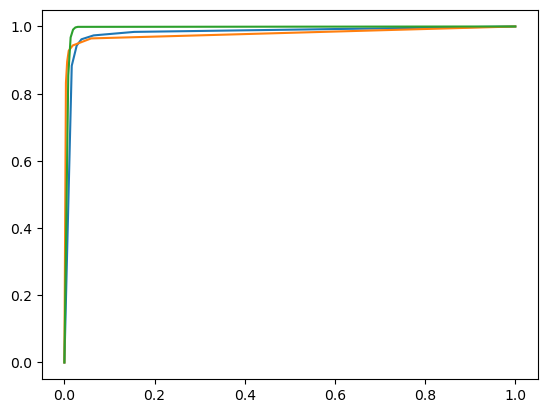

In [7]:
evaluate_model(KNeighborsClassifier(), train, t)

Model klasyfikacji KNN osiągnął ogólną dokładność na poziomie 96.15%. Z raportu klasyfikacji wynika, że model dobrze radzi sobie z klasyfikacją obiektów GALAXY oraz QSO, uzyskując odpowiednio 97% i 96% precyzji. Jednakże, dla klasy QSO (kwazarów) precyzja jest nieco niższa - 96%, co sugeruje, że model może mieć trudności w identyfikacji tej klasy.

Analiza macierzy pomyłek pokazuje, że model często myli klasy GALAXY z QSO, co może wymagać dalszej optymalizacji.

Średnie AUC dla każdej klasy oraz Gini coefficient wskazują, że model ma ogólnie dobrą zdolność do rozróżniania klas, z wynikami powyżej 0.95 dla każdej klasy.

### Model 2 - RandomForestClassifier

Dokładność całkowita (Accuracy): 0.9636666666666667

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.96      0.98      0.97     12538
         QSO       0.96      0.93      0.94      3973
        STAR       0.98      0.96      0.97      4489

    accuracy                           0.96     21000
   macro avg       0.96      0.95      0.96     21000
weighted avg       0.96      0.96      0.96     21000


Confusion matrix:
[[12257   172   109]
 [  283  3689     1]
 [  198     0  4291]]
AUC dla klasy GALAXY: 0.9891728577881453
Gini dla klasy GALAXY: 0.9783457155762907
 
AUC dla klasy QSO: 0.9882980970792292
Gini dla klasy QSO: 0.9765961941584584
 
AUC dla klasy STAR: 0.9975629024678377
Gini dla klasy STAR: 0.9951258049356755
 
Średni AUC: 0.9916779524450708
Gini coefficient: 0.9833559048901417


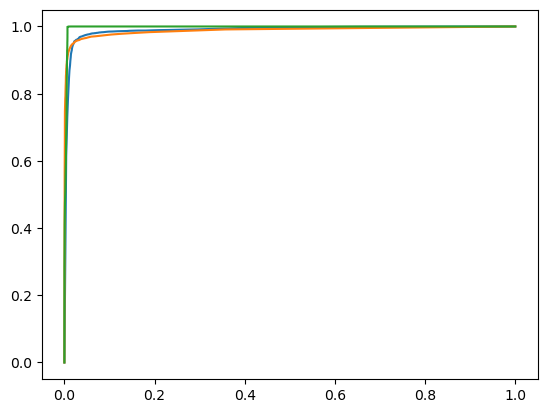

In [8]:
evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42), train, t)

Model RandomForestClassifier osiągnął nieznacznie wyższą dokładność całkowitą w porównaniu do modelu KNN.
Wartości AUC dla klasy GALAXY i QSO są nieznacznie wyższe w przypadku drugiego modelu, podczas gdy dla klasy STAR wartość AUC jest zbliżona. Oznacza to, że RandomForestClassifier model ma lepszą zdolność do rozróżniania poszczególnych klas niż KNN

### Model 3 xboost

In [9]:
evaluate_model(XGBClassifier(n_estimators=100, random_state=42), train, t, 2)

Dokładność całkowita (Accuracy): 0.9535238095238096

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     12538
           1       0.95      0.93      0.94      3973
           2       0.97      0.91      0.94      4489

    accuracy                           0.95     21000
   macro avg       0.96      0.94      0.95     21000
weighted avg       0.95      0.95      0.95     21000


Confusion matrix:
[[12243   188   107]
 [  286  3686     1]
 [  393     1  4095]]
AUC dla klasy GALAXY: 0.9888218756130029
Gini dla klasy GALAXY: 0.9776437512260059
 
AUC dla klasy QSO: 0.9922263792965234
Gini dla klasy QSO: 0.9844527585930467
 
AUC dla klasy STAR: 0.9966394208339394
Gini dla klasy STAR: 0.9932788416678788
 
Średni AUC: 0.9925625585811552
Gini coefficient: 0.9851251171623103
AUC dla klasy GALAXY: 0.9888218756130029
Gini dla klasy GALAXY: 0.9776437512260059
 
AUC dla klasy QSO: 0.9922263792965234
Gini dla klasy QSO: 0.9844

Model XGBoost poprawnie sklasyfikował 95.3% wszystkich próbek. Model osiągnął wysokie wartości precision dla wszystkich klas, co oznacza, że dobrze radził sobie zarówno z minimalizacją fałszywie pozytywnych jak i fałszywie negatywnych przypadków.
Model poprawnie zidentyfikował większość przypadków dla wszystkich klas, najwięcej błędów pojawiło się z klasyfikacją star i galaxy - model przewidział błędnie 400 razy klasę galaxy zamiast star.

### Model 4 Gradient Boosting

Dokładność całkowita (Accuracy): 0.9657142857142857

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.96      0.98      0.97     12538
         QSO       0.96      0.91      0.94      3973
        STAR       0.98      0.97      0.97      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.96      0.96     21000
weighted avg       0.97      0.97      0.97     21000


Confusion matrix:
[[12277   152   109]
 [  341  3631     1]
 [  116     1  4372]]
AUC dla klasy GALAXY: 0.9888759961256423
Gini dla klasy GALAXY: 0.9777519922512845
 
AUC dla klasy QSO: 0.9912489781150503
Gini dla klasy QSO: 0.9824979562301006
 
AUC dla klasy STAR: 0.9963068425096191
Gini dla klasy STAR: 0.9926136850192382
 
Średni AUC: 0.9921439389167706
Gini coefficient: 0.9842878778335411


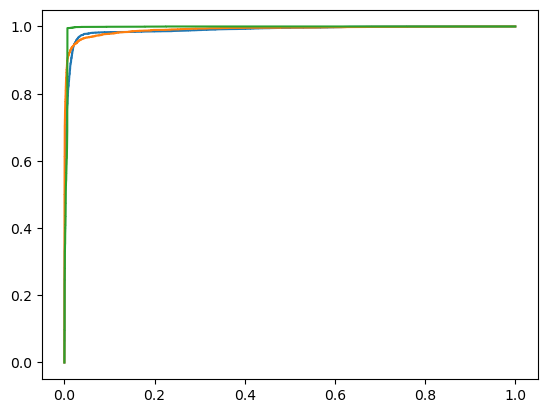

In [10]:
evaluate_model(GradientBoostingClassifier(n_estimators=100, random_state=42), train, t)

Model Gradient Boosting poprawnie sklasyfikował 96.6% wszystkich próbek.
Macierz pomyłek pokazuje, że model poprawnie rozróżnia klasy star i quasar (tylko jeden błąd)!

Podsumowując, zarówno model XGBoost, jak i Gradient Boosting wykazały się bardzo dobrymi wynikami, osiągając wysoką dokładność oraz skuteczność w klasyfikacji danych.

### Model 5: Regresja logistyczna

Dokładność całkowita (Accuracy): 0.9532380952380952

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96     12538
         QSO       0.94      0.88      0.91      3973
        STAR       0.94      1.00      0.97      4489

    accuracy                           0.95     21000
   macro avg       0.95      0.95      0.95     21000
weighted avg       0.95      0.95      0.95     21000


Confusion matrix:
[[12054   205   279]
 [  491  3479     3]
 [    0     4  4485]]
AUC dla klasy GALAXY: 0.9830761895796128
Gini dla klasy GALAXY: 0.9661523791592257
 
AUC dla klasy QSO: 0.9850521974168416
Gini dla klasy QSO: 0.9701043948336832
 
AUC dla klasy STAR: 0.9955970542546151
Gini dla klasy STAR: 0.9911941085092302
 
Średni AUC: 0.9879084804170232
Gini coefficient: 0.9758169608340463


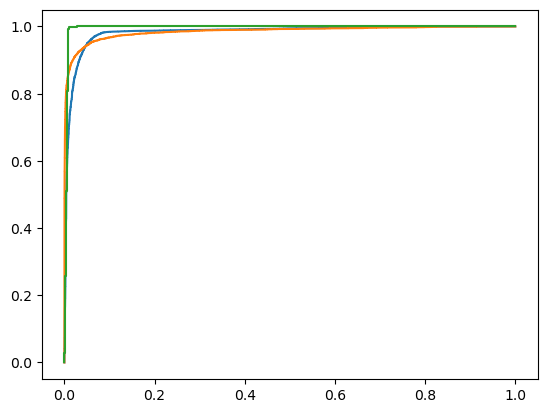

In [11]:
evaluate_model(LogisticRegression(max_iter=1000, random_state=42), train, t)

Model regresji logistycznej ma nieco niższą dokładność niż modele XGBoost i Gradient Boosting. Na razie najlepiej przewiduje klasę Star - prawie brak pomyłek w klasyfikowaniu star i quasar oraz nie zakwalifikował błędnie żadnej gwiazdy do galaktyki!

### Model 6: Model Markova

In [12]:
evaluate_model(ClassifierChain(base_estimator=DecisionTreeClassifier(), order='random', random_state=42), train, t, 3)

Dokładność całkowita (Accuracy): 0.9003809523809524

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     12538
           1       0.78      0.92      0.85      3973
           2       0.97      0.72      0.83      4489

   micro avg       0.90      0.90      0.90     21000
   macro avg       0.89      0.87      0.87     21000
weighted avg       0.91      0.90      0.90     21000
 samples avg       0.90      0.90      0.90     21000

AUC dla klasy 0: 0.9206303077359081
Gini dla klasy 0: 0.8412606154718163
 
AUC dla klasy 1: 0.9299854906860812
Gini dla klasy 1: 0.8599709813721623
 
AUC dla klasy 2: 0.8575597528903925
Gini dla klasy 2: 0.7151195057807851
 
Średni AUC: 0.9027251837707939
Gini coefficient: 0.8054503675415878


Model Markov Chain osiąga dobre wyniki, jednak w porówaniu z posostałymi modelami nie jest aż tak efektywny

### Model 7 Adaptacyjne drzewa decyzyjne

Dokładność całkowita (Accuracy): 0.8987142857142857

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.93      0.96      0.94     12538
         QSO       0.77      0.92      0.83      3973
        STAR       0.97      0.72      0.82      4489

    accuracy                           0.90     21000
   macro avg       0.89      0.86      0.87     21000
weighted avg       0.91      0.90      0.90     21000


Confusion matrix:
[[12020   422    96]
 [  333  3639     1]
 [  589   686  3214]]
AUC dla klasy GALAXY: 0.9248639512860342
Gini dla klasy GALAXY: 0.8497279025720683
 
AUC dla klasy QSO: 0.9254297127564428
Gini dla klasy QSO: 0.8508594255128856
 
AUC dla klasy STAR: 0.8550487528117203
Gini dla klasy STAR: 0.7100975056234407
 
Średni AUC: 0.9017808056180657
Gini coefficient: 0.8035616112361315


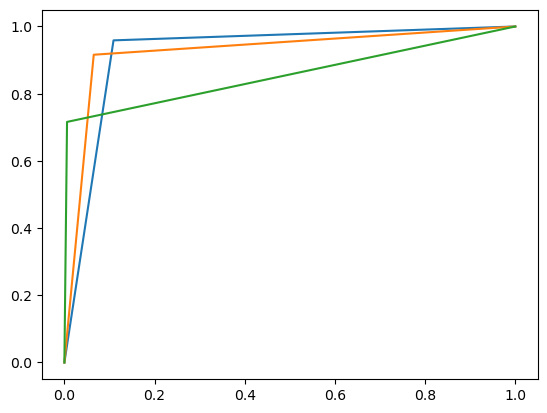

In [13]:
evaluate_model(DecisionTreeClassifier(), train, t)

Model DecisionTreeClassifier osiąga gorsze wyniki niż np. regresja logistyczna czy xgboost. Bardzo słabo przewiduje klasę STAR, co jest atutem pozostałych modeli.

### Model 8 RandomForestClassifier, ramka danych bez 'field_ID', 'cam_col',  z 'r+i+z'
Sprowadzenie ramki danych do dotychczas używanej formy wynikało z próby maksymalizacji wyników różnych modeli w etapie inźynierii cech, natomiast RandomForestClassifier jako jedyny osiągał lepsze wyniki na mniej obrobionej ramce danych. Z tego powodu, metodą prób i błędów, okazało się, że ten model osiąga najlepsze notowania dla ramki danych zmodefikowanej w sposób widoczny w funkcji poniższej 'modify_data_2'.

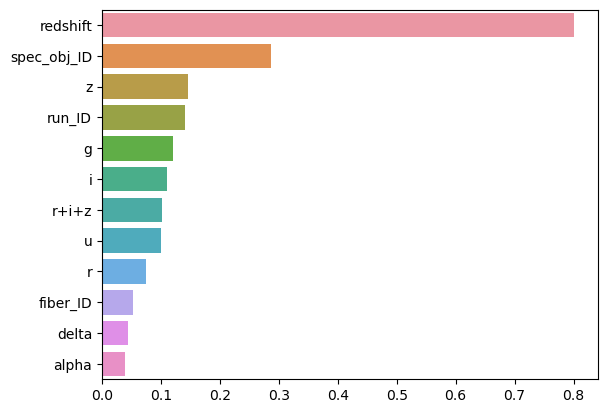

Dokładność całkowita (Accuracy): 0.9735238095238096

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98     12538
         QSO       0.96      0.93      0.95      3973
        STAR       0.98      0.99      0.98      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.97      0.97     21000
weighted avg       0.97      0.97      0.97     21000


Confusion matrix:
[[12288   142   108]
 [  275  3697     1]
 [   30     0  4459]]
AUC dla klasy GALAXY: 0.992262090957976
Gini dla klasy GALAXY: 0.984524181915952
 
AUC dla klasy QSO: 0.9908781260647446
Gini dla klasy QSO: 0.9817562521294891
 
AUC dla klasy STAR: 0.9984388517107998
Gini dla klasy STAR: 0.9968777034215996
 
Średni AUC: 0.9938596895778401
Gini coefficient: 0.9877193791556802


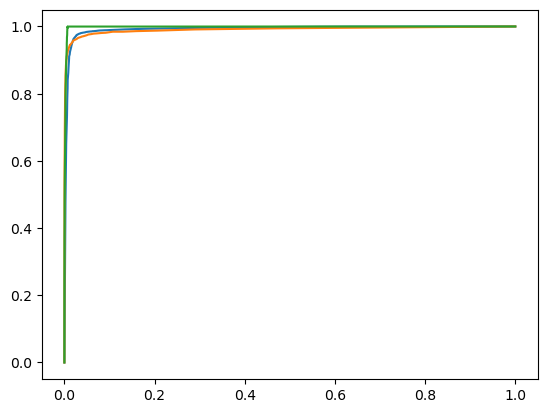

In [184]:
def modify_data_2(df):
    
    df = df[df['u'] > 0]
    df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)

    # Normalizacja
    columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
    df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

    # Standaryzacja
    columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z']
    df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])

    df = df.drop(['rerun_ID', 'obj_ID', 'plate', 'MJD', 'field_ID', 'cam_col'], axis = 1)
#     df = df.drop(['r', 'i', 'z'], axis = 1)
#     df = df.drop(['r+i+z'], axis = 1)
    
    return df

train2 = modify_data_2(development_unit_df.copy())
t2 = modify_data_2(test.copy())

# Wykres informacji wzajmenych
scores = pd.Series(mutual_info_classif(train2.drop('class', axis = 1), train2['class']),
                   index=train2.drop('class', axis = 1).columns).sort_values(ascending=False)
sns.barplot(x=scores.values, y=list(scores.index))
plt.show()

evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42), train2, t2)

## Wyniki:

Model 1 - KNeighboursClassifier\
z usuwaniem outlierów: 0.9618095238095238 (accuracy)\
bez usuwana outlierów: 0.9616666666666667 (accuracy)\
Średni AUC: 0.9839795090122149\
Gini coefficient: 0.9679590180244297

Model 2 - RandomForestClassifier\
z usuwaniem outlierów: 0.963\
bez usuwana outlierów: 0.9636666666666667\
Średni AUC: 0.9916779524450708\
Gini coefficient: 0.9833559048901417

Model 3 xboost\
z usuwaniem outlierów: 0.9556190476190476\
bez usuwana outlierów: 0.9535238095238096\
Średni AUC: 0.9925625585811552\
Gini coefficient: 0.9851251171623103

Model 4 Gradient Boosting\
z usuwaniem outlierów: 0.9656666666666667\
bez usuwana outlierów: 0.9657142857142857\
Średni AUC: 0.9921439389167706\
Gini coefficient: 0.9842878778335411

Model 5: Regresja logistyczna\
z usuwaniem outlierów: 0.9535238095238096\
bez usuwana outlierów: 0.9532380952380952\
Średni AUC: 0.9879084804170232\
Gini coefficient: 0.9758169608340463

Model 6: Model Markova\
z usuwaniem outlierów: 0.9088095238095238\
bez usuwana outlierów: 0.9130952380952381\
Średni AUC: 0.9085411993293854\
Gini coefficient: 0.8170823986587707

Model 7 Adaptacyjne drzewa decyzyjne\
z usuwaniem outlierów: 0.8979047619047619\
bez usuwana outlierów: 0.9034761904761904\
Średni AUC: 0.9110128427981916\
Gini coefficient: 0.8220256855963832

Model 8 RandomForestClassifier, ramka danych bez 'field_ID', 'cam_col'\
bez usuwana outlierów:\
0.9722857142857143 'r' 'i' 'z'\
0.9726666666666667 'r+i+z'\
**0.9735238095238096 'r' 'i' 'z' 'r+i+z' <-- najlepsze accuracy**\
**Średni AUC: 0.9938596895778401\ <-- najlepsze AUC**\
**Gini coefficient: 0.9877193791556802 <-- najlepsze Gini**

<!---
## Wnioski:

1) najwyższa dokładność ogólna: knn, randomForest, gradient boosting ~ 0.96


2) najwyższa dokładność:


        dla Star: randomForest, gradient boosting ~ 0.98
        
        dla Galaxy: knn ~ 0.97
        
        dla Quasar: knn, gradient boosting ~ 0.96
        
        
3) najwyższy średni auc: gradient, boosting, xboost, randomForest  ~ 0.99


4) najwyższy auc:

        dla Star: wszystkie oprócz Markowa i DecisionTreeClassifier ~ 0.99
        
        dla Galaxy: wszystkie oprócz Markowa i DecisionTreeClassifier ~ 0.99
        
        dla Quasar: xboost, gradient boosting ~ 0.99

najsłabiej sobie radzi Model Markova

Decision Tree Classifier bardzo słabo przewiduję klasę STAR, dla każdego innego modelu predykcyjność STAR jest najwyższa, często bliska 100 %
-->

## Strojenie hiperparametrów dla wybranych modeli, wybór najlepszego

#### Do kolejnej części wybrano te modele, które osiągnęły najlepsze wyniki z standardowymi, niezmienionymi parametrami. Są to:

1) Model 8 RandomForestClassifier, ramka danych bez 'field_ID', 'cam_col', z 'r+i+z'

2) Model 4 Gradient Boosting

3) Model 1 KNeighboursClassifier

3) Model 5 Logistic Regression 

1) Model 3 XGBoost

## Strojenie hiperpatametrów
### Model 8 RandomForestClassifier, ramka danych bez 'field_ID', 'cam_col'

In [9]:
best_rfc, classification_rep_forest, conf_matrix_forest, mean_auc_forest, mean_gini_forest =\
hiperparams_model(RandomForestClassifier(), train2, t2,
                   {
        'random_state': [42],
        'n_estimators': [50, 100, 150],  # Liczba drzew w lesie
        'max_depth': [None, 10, 20, 30],  # Maksymalna głębokość drzewa
        'min_samples_split': [2, 5, 10],  # Minimalna liczba próbek wymagana do podziału węzła
        'min_samples_leaf': [1, 2, 4]  # Minimalna liczba próbek wymagana do utworzenia liścia
})

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Najlepsze parametry: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Dokładność: 0.9733809523809523
Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98     12538
         QSO       0.96      0.93      0.95      3973
        STAR       0.98      0.99      0.98      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.97      0.97     21000
weighted avg       0.97      0.97      0.97     21000

Confusion Matrix:
[[12279   150   109]
 [  271  3701     1]
 [   28     0  4461]]
AUC dla klasy 'GALAXY': 0.9926237473721579
Gini dla klasy 'GALAXY': 0.9852474947443157
AUC dla klasy 'QSO': 0.9919325876044934
Gini dla klasy 'QSO': 0.9838651752089869
AUC dla klasy 'STAR': 0.9983402250353117
Gini dla klasy 'STAR': 0.9966804500706234
Średnie AUC: 0.994298853337321
Średni Gini: 0.988597706674642

### Model 4 Gradient Boosting

In [10]:
best_gb, classification_rep_forest, conf_matrix_forest, mean_auc_forest, mean_gini_forest =\
hiperparams_model(GradientBoostingClassifier(), train2, t2,
                  {
        'random_state': [42],
        'learning_rate': [0.1, 0.3],  # Współczynnik uczenia
        'n_estimators': [50, 100],  # Liczba estymatorów
        'max_depth': [3, 6],  # Maksymalna głębokość drzewa
        'min_samples_split': [2, 5, 10],  # Minimalna liczba próbek wymagana do podziału węzła
        'min_samples_leaf': [1, 2],  # Minimalna liczba próbek wymagana do utworzenia liścia
        'subsample': [0.8, 1.0],  # Procent próbek używanych do trenowania każdego estymatora
        'max_features': ['sqrt', 'log2']  # Maksymalna liczba cech branych pod uwagę przy podziale węzła
    })

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Najlepsze parametry: {'learning_rate': 0.1, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1.0}
Dokładność: 0.9728095238095238
Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98     12538
         QSO       0.96      0.93      0.94      3973
        STAR       0.98      0.99      0.98      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.97      0.97     21000
weighted avg       0.97      0.97      0.97     21000

Confusion Matrix:
[[12272   156   110]
 [  273  3699     1]
 [   30     1  4458]]
AUC dla klasy 'GALAXY': 0.9929225506622477
Gini dla klasy 'GALAXY': 0.9858451013244953
AUC dla klasy 'QSO': 0.9933733413526563
Gini dla klasy 'QSO': 0.9867466827053126
AUC dla klasy 'STAR': 0.9986660303649543
Gini dla klasy 'STAR': 0.9973320607299085
Ś

### Model 5: Regresja logistyczna

In [68]:
best_rf_clf_forest, classification_rep_forest, conf_matrix_forest, mean_auc_forest, mean_gini_forest =\
hiperparams_model(LogisticRegression(max_iter=1000), train, t,
                  {
        'random_state': [42],
        'C': [0.01, 0.1, 1.0, 10.0],  # Parametr regularyzacji
        'penalty': ['l1', 'l2'],  # Rodzaj normy regularyzacji
        'solver': ['liblinear', 'saga'],  # Algorytm optymalizacji
        'class_weight': [None, 'balanced']  # Wagi klas
    })

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Najlepsze parametry: {'C': 10.0, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
Dokładność: 0.9595238095238096
Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.96      0.97      0.97     12538
         QSO       0.94      0.88      0.91      3973
        STAR       0.97      1.00      0.98      4489

    accuracy                           0.96     21000
   macro avg       0.96      0.95      0.95     21000
weighted avg       0.96      0.96      0.96     21000

Confusion Matrix:
[[12180   204   154]
 [  487  3485     1]
 [    0     4  4485]]
AUC dla klasy 'GALAXY': 0.9867066184504613
Gini dla klasy 'GALAXY': 0.9734132369009225
AUC dla klasy 'QSO': 0.9851683127274605
Gini dla klasy 'QSO': 0.970336625454921
AUC dla klasy 'STAR': 0.9973433805357544
Gini dla klasy 'STAR': 0.9946867610715089
Średnie AUC: 0.9897394372378922
Średni Gini: 0.9794788744757842


### Model 3 xboost

In [69]:
best_rf_clf_forest, classification_rep_forest, conf_matrix_forest, mean_auc_forest, mean_gini_forest =\
hiperparams_model(XGBClassifier(), train, t,
                  {
        'random_state': [42],
        'max_depth': [3, 6, 9],  # Maksymalna głębokość drzewa
        'learning_rate': [0.1, 0.3],  # Współczynnik uczenia
        'n_estimators': [50, 100],  # Liczba drzew
        'subsample': [0.8, 1.0],  # Procent próbek używanych do trenowania każdego drzewa
        'colsample_bytree': [0.8, 1.0],  # Procent kolumn używanych do trenowania każdego drzewa
    })

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Najlepsze parametry: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.8}
Dokładność: 0.9550952380952381
Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.95      0.98      0.96     12538
         QSO       0.95      0.92      0.94      3973
        STAR       0.97      0.92      0.95      4489

    accuracy                           0.96     21000
   macro avg       0.96      0.94      0.95     21000
weighted avg       0.96      0.96      0.95     21000

Confusion Matrix:
[[12252   177   109]
 [  302  3670     1]
 [  354     0  4135]]
AUC dla klasy 'GALAXY': 0.9896019056452692
Gini dla klasy 'GALAXY': 0.9792038112905384
AUC dla klasy 'QSO': 0.9920147922184146
Gini dla klasy 'QSO': 0.9840295844368292
AUC dla klasy 'STAR': 0.9971977139281063
Gini dla klasy 'STAR': 0.9943954278562126
Średnie AUC: 0.99293813726393
Średni Gini: 0.9858

### Ensemble model - połączenie forest, xgb oraz regression

In [98]:
# Definicja modelu ensemble
ensemble_model = VotingClassifier(estimators=[
    ('xgb', best_gb),
    ('rf', best_rfc)
], voting='hard')

ensemble_model, accuracy, classification_rep, conf_matrix =\
ensemble_model_function(ensemble_model, train2, t2)

Dokładność: 0.9723809523809523
Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     12538
         QSO       0.96      0.93      0.94      3973
        STAR       0.98      0.99      0.98      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.97      0.97     21000
weighted avg       0.97      0.97      0.97     21000

Confusion Matrix:
[[12299   133   106]
 [  294  3678     1]
 [   44     2  4443]]


## Walidacja krzyżowa

In [10]:
X = pd.concat([train, t])
y = X['class']
X = X.drop('class', axis=1)

X2 = pd.concat([train2, t2])
y2 = X2['class']
X2 = X2.drop('class', axis=1)

In [72]:
# KNeighborsClassifier
scores = cross_val_score(KNeighborsClassifier(), X, y, cv=5)
print(scores)
print(f"{scores.mean()} accuracy with a standard deviation of {scores.std()}")

[0.96114286 0.95907143 0.96257143 0.96064286 0.96264286]
0.96 accuracy with a standard deviation of 0.00


In [74]:
# GradientBoostingClassifier
scores = cross_val_score(best_gb, X2, y2, cv=5)
print(scores)
print(f"{scores.mean()} accuracy with a standard deviation of {scores.std()}")

[0.97692857 0.97742857 0.97735714 0.977      0.97657143]
0.98 accuracy with a standard deviation of 0.00


In [94]:
# RandomForestClassifier
cores = cross_val_score(best_rfc, X2, y2, cv=5)
print(scores)
print(f"{scores.mean()} accuracy with a standard deviation of {scores.std()}")

[0.97671429 0.9745     0.97571429 0.97535714 0.97435714]
0.9753285714285713 accuracy with a standard deviation of 0.0008602325267042841


In [99]:
# ensemble_model
scores = cross_val_score(ensemble_model, X2, y2, cv=5)
print(scores)
print(f"{scores.mean()} accuracy with a standard deviation of {scores.std()}")

[0.97764286 0.97785714 0.97771429 0.97764286 0.97578571]
0.9773285714285713 accuracy with a standard deviation of 0.0007753866711492704


## Wyniki testowania

Najlepiej sprawował się model 

**Model 8 RandomForestClassifier** 

na **danych**

po odrzuceniu wiersza, dla którego u < 0,

bez kolumn: rerun_ID, obj_ID, plate, MJD, field_ID, cam_col,

z utworzoną kolumną r+i+z,

ze znormalizowanymi kolumnami: 'spec_obj_ID', 'alpha', 'fiber_ID',

i zestandardyzowanymi: 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'r+i+z'.

**Najlepsze hiperparametry**:

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

Model został zwalidowany między innymi walidacją krzyżową. Jego wyniki są następujące:

**accuracy**: 0.973

**AUC**: 0.994

**GINI**: 0.989

i 

**Model 4 GradientBoostingClassifier** 

na **danych**

po odrzuceniu wiersza, dla którego u < 0,

bez kolumn: rerun_ID, obj_ID, plate, MJD, field_ID, cam_col,

z utworzoną kolumną r+i+z,

ze znormalizowanymi kolumnami: 'spec_obj_ID', 'alpha', 'fiber_ID',

i zestandardyzowanymi: 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'r+i+z'.

**Najlepsze hiperparametry**:

{'learning_rate': 0.1, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}

Model został zwalidowany między innymi walidacją krzyżową. Jego wyniki są następujące:

**accuracy**: 0.973

**AUC**: 0.995

**GINI**: 0.989

i

**model ensemble**

będący połączeniem dwóch poprzednich modeli o **średniej dokładności** 0.972.

Funkcja ustalająca najlepsze hiperparametry używa kroswalidacji.

##  Strojenie hiperparametrów na mniejszej próbie
Po przeanalizowaniu wyników testów trzech wyłonionych kandydatów miało bardzo podobny wynik, a minimalne różnice mogą wynikać z losowości metod używanych przez rozpatrywane modele. Ostatecznie został wybrany **Model 4 GradientBoostingClassifier**.


            'loss': #{‘log_loss’, ‘exponential’}, default=’log_loss’
            'learning_rate': #float, default=0.1
            'n_estimators': #int, default=100
            'subsample': #float, default=1.0
            'criterion': #{‘friedman_mse’, ‘squared_error’}, default=’friedman_mse’
            'min_samples_split': #int or float, default=2
            'min_samples_leaf': #int or float, default=1
            'min_weight_fraction_leaf': #float, default=0.0
            'max_depth': #int or None, default=3
            'min_impurity_decrease': #float, default=0.0
            'init': #estimator or ‘zero’, default=None
            'random_state': #int, RandomState instance or None, default=None
            'max_features': #{‘sqrt’, ‘log2’}, int or float, default=None
            'verbose': #int, default=0
            'max_leaf_nodes': #int, default=None
            'warm_start': #bool, default=False
            'validation_fraction': #float, default=0.1
            'n_iter_no_change': #int, default=None
            'tol': #float, default=1e-4
            'ccp_alpha': #non-negative float, default=0.0

In [185]:
fraction=0.1
full = pd.concat([train2, t2])
y_full = full['class']
X_full= full.drop('class', axis=1)
dev2=train2.sample(frac=fraction, random_state=42)
test2=t2.sample(frac=fraction, random_state=42)
y_train = dev2['class']
X_train = dev2.drop('class', axis=1)
y_test = test2['class']
X_test = test2.drop('class', axis=1)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
model_raw=GradientBoostingClassifier()
model_raw.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [186]:
# Trenowanie
model_raw.fit(X_train, y_train)

# Testowanie
print('Testowanie:')
print(f'mean_accuracy: {model_raw.score(X_test, y_test)}\n')

# Kroswalidacja
print('\nKroswalidacja (mean, sd):')
results=cross_val_score(model_raw, X, y, cv=5, scoring='accuracy')
print(f'accuracy: {np.mean(results)}, {np.std(results)}')

# Grid search
print('\nGrid search:')
grid = GridSearchCV(estimator=GradientBoostingClassifier(),param_grid={
    'max_depth': [3, 5, 6],
    'criterion': ['friedman_mse', 'squared_error'],
    'ccp_alpha': [0, 0.05]
},cv = 3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
best_model_1=grid_result.best_estimator_
best_model_1.score(X_test, y_test)

# Random search
print('\nRandom search:')
random = RandomizedSearchCV(estimator=GradientBoostingClassifier(), param_distributions={
    'max_depth': randint(1, 6+1),
    'criterion': ['friedman_mse', 'squared_error'],
    'ccp_alpha': uniform(0, 0.05)
},cv = 3, n_jobs=-1, n_iter=10)
random_result = random.fit(X_train, y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
best_model_1=random_result.best_estimator_
best_model_1.score(X_test, y_test)
                           
# Bayes optimization
print('\nBayes optimization:')
opt = BayesSearchCV(GradientBoostingClassifier(),{ 
    'max_depth': (1, 6),
    'criterion': ['friedman_mse', 'squared_error'],
    }, n_iter=5, cv=3)
opt_result=opt.fit(X_train, y_train)
print("Best: %f using %s" % (opt_result.best_score_, opt_result.best_params_))
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

Testowanie:
mean_accuracy: 0.9647619047619047


Kroswalidacja (mean, sd):
accuracy: 0.9730000000000001, 0.004271404682207416

Grid search:
Best: 0.972040 using {'ccp_alpha': 0, 'criterion': 'friedman_mse', 'max_depth': 5}

Random search:
Best: 0.959796 using {'ccp_alpha': 0.002950186726245796, 'criterion': 'friedman_mse', 'max_depth': 4}

Bayes optimization:
Best: 0.971224 using OrderedDict([('criterion', 'friedman_mse'), ('max_depth', 3)])
val. score: 0.9712239877096293
test score: 0.9642857142857143


In [187]:
# Random search
print('\nRandom search:')
random = RandomizedSearchCV(estimator=GradientBoostingClassifier(), param_distributions={
        'loss': ['log_loss', 'exponential'],#{‘log_loss’, ‘exponential’}, default=’log_loss’
        'learning_rate': [0.05, 0.1, 0.15, 0.2],#float, default=0.1
        'n_estimators': [50, 100, 150],#int, default=100
        'subsample': [0.5, 1.0, 1.5, 2.0],#float, default=1.0
        'criterion': ['friedman_mse', 'squared_error'],#{‘friedman_mse’, ‘squared_error’}, default=’friedman_mse’
        'min_samples_split': [1, 2, 3, 4, 5],#int or float, default=2
        'min_samples_leaf': [1, 2, 3, 4, 5],#int or float, default=1
        'min_weight_fraction_leaf': [0.0, 0.05, 0.1],#float, default=0.0
        'max_depth': [2, 3, 6, None],#int or None, default=3
        'min_impurity_decrease': [0.0, 0.05, 0.1],#float, default=0.0
        'init': [None],
        'random_state': [42],
        'max_features': ['sqrt', 'log2', None],#{‘sqrt’, ‘log2’}, int or float, default=None
        'verbose': [0],
        'max_leaf_nodes': [None],#int, default=None
        'warm_start': [False, True],#bool, default=False
        'validation_fraction': [0.1, 0.15, 0.2],#float, default=0.1
        'n_iter_no_change':[None],
        'tol': [0.5*1e-4, 1e-4, 2*1e-4],#float, default=1e-4
        'ccp_alpha': [0.0, 0.02]#non-negative float, default=0.0
},cv = 3, n_jobs=-1, n_iter=1000)
random_result = random.fit(X_train, y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
best_model_1=random_result.best_estimator_
best_model_1.score(X_test, y_test)


Random search:
Best: 0.973672 using {'warm_start': False, 'verbose': 0, 'validation_fraction': 0.15, 'tol': 0.0001, 'subsample': 1.0, 'random_state': 42, 'n_iter_no_change': None, 'n_estimators': 150, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': 6, 'loss': 'log_loss', 'learning_rate': 0.15, 'init': None, 'criterion': 'friedman_mse', 'ccp_alpha': 0.0}


0.9638095238095238

In [188]:
# Testowanie na pełnych danych
print('Testowanie:')
print(f'mean_accuracy: {best_model_1.score(X_full, y_full)}')

Testowanie:
mean_accuracy: 0.9728


In [189]:
# Random search
print('\nRandom search:')
random = RandomizedSearchCV(estimator=GradientBoostingClassifier(), param_distributions={
        'loss': ['log_loss'],
        'learning_rate': [0.03, 0.05, 0.1],#float, default=0.1
        'n_estimators': [100, 150],#int, default=100
        'subsample': [0.5, 1.0, 1.5],#float, default=1.0
        'criterion': ['friedman_mse', 'squared_error'],#{‘friedman_mse’, ‘squared_error’}, default=’friedman_mse’
        'min_samples_split': [2, 3, 4, 5],#int or float, default=2
        'min_samples_leaf': [1, 2, 3, 4],#int or float, default=1
        'min_weight_fraction_leaf': [0.0, 0.02, 0.03],#float, default=0.0
        'max_depth': [3, 5, 7, 8, None],#int or None, default=3
        'min_impurity_decrease': [0.0, 0.05, 0.6],#float, default=0.0
        'init': [None],
        'random_state': [42],
        'max_features': [None],
        'verbose': [0],
        'max_leaf_nodes': [None],#int, default=None
        'warm_start': [False, True],#bool, default=False
        'validation_fraction': [0.1, 0.15, 0.2, 0.25],#float, default=0.1
        'n_iter_no_change':[None],
        'tol': [1e-5, 0.5*1e-4, 1e-4],#float, default=1e-4
        'ccp_alpha': [0.0, 0.01, 0.03]#non-negative float, default=0.0
},cv = 3, n_jobs=-1, n_iter=1000)
random_result = random.fit(X_train, y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
best_model_1=random_result.best_estimator_
best_model_1.score(X_test, y_test)


Random search:
Best: 0.974081 using {'warm_start': False, 'verbose': 0, 'validation_fraction': 0.2, 'tol': 0.0001, 'subsample': 0.5, 'random_state': 42, 'n_iter_no_change': None, 'n_estimators': 150, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 3, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.05, 'max_leaf_nodes': None, 'max_features': None, 'max_depth': None, 'loss': 'log_loss', 'learning_rate': 0.05, 'init': None, 'criterion': 'friedman_mse', 'ccp_alpha': 0.0}


0.9685714285714285

In [190]:
# Testowanie na pełnych danych
print('Testowanie:')
print(f'mean_accuracy: {best_model_1.score(X_full, y_full)}')

Testowanie:
mean_accuracy: 0.9717857142857143


In [191]:
# Grid search
print('\nRandom search:')
random = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid={
        'loss': ['log_loss'],
        'learning_rate': [0.1],#float, default=0.1
        'n_estimators': [150],#int, default=100
        'subsample': [0.5, 0.8],#float, default=1.0
        'criterion': ['friedman_mse'],#{‘friedman_mse’, ‘squared_error’}, default=’friedman_mse’
        'min_samples_split': [2, 3],#int or float, default=2
        'min_samples_leaf': [1, 2, 4],#int or float, default=1
        'min_weight_fraction_leaf': [0.0, 0.01],#float, default=0.0
        'max_depth': [6, 8, 9],#int or None, default=3
        'min_impurity_decrease': [0.0, 0.01],#float, default=0.0
        'init': [None],
        'random_state': [42],
        'max_features': [None],
        'verbose': [0],
        'max_leaf_nodes': [None],#int, default=None
        'warm_start': [True],#bool, default=False
        'validation_fraction': [0.1],#float, default=0.1
        'n_iter_no_change':[None],
        'tol': [1e-4],#float, default=1e-4
        'ccp_alpha': [0.0, 0.005]#non-negative float, default=0.0
},cv = 3, n_jobs=-1)
random_result = random.fit(X_train, y_train)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
best_model_1=random_result.best_estimator_
best_model_1.score(X_test, y_test)


Random search:
Best: 0.974081 using {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.8, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}


0.9661904761904762

In [192]:
# Testowanie na pełnych danych
print('Testowanie:')
print(f'mean_accuracy: {best_model_1.score(X_full, y_full)}')

Testowanie:
mean_accuracy: 0.9734


## Ostateczne dostrajanie hiperparametrów dla Model 4 RandomForestClassifier
Poniżej jest ostateczne testowanie metodą grid search na podstawie wcześniejszych testów.

In [8]:
best_gb, classification_rep_forest, conf_matrix_forest, mean_auc_forest, mean_gini_forest =\
hiperparams_model(GradientBoostingClassifier(), train2, t2,
                  {
#             'loss': 'log_loss', #{‘log_loss’, ‘exponential’}, default=’log_loss’
            'learning_rate': [0.1],#float, default=0.1
            'n_estimators': [100],#int, default=100
            'subsample': [0.8, 0.6],#float, default=1.0
#             'criterion': 'friedman_mse',#{‘friedman_mse’, ‘squared_error’}, default=’friedman_mse’
            'min_samples_split': [10, 16],#int or float, default=2
            'min_samples_leaf': [2, 4],#int or float, default=1
#             'min_weight_fraction_leaf': 0.0, #float, default=0.0
            'max_depth': [6, 12],#int or None, default=3
#             'min_impurity_decrease': 0.0,#float, default=0.0
#             'init': None,#estimator or ‘zero’, default=None
            'random_state': [42],#int, RandomState instance or None, default=None
            'max_features': [None, 'sqrt'],#{‘sqrt’, ‘log2’}, int or float, default=None
#             'verbose': 0,#int, default=0
#             'max_leaf_nodes': [None],#int, default=None
#             'warm_start': False,#bool, default=False
#             'validation_fraction': 0.1,#float, default=0.1
#             'n_iter_no_change': None,#int, default=None
#             'tol': 1e-4,#float, default=1e-4
#             'ccp_alpha': 0.0#non-negative float, default=0.0
    })

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Najlepsze parametry: {'learning_rate': 0.1, 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 16, 'n_estimators': 100, 'random_state': 42, 'subsample': 0.6}
Dokładność: 0.9687142857142857
Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97     12538
         QSO       0.96      0.94      0.95      3973
        STAR       0.98      0.97      0.97      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.96      0.96     21000
weighted avg       0.97      0.97      0.97     21000

Confusion Matrix:
[[12275   154   109]
 [  250  3722     1]
 [  143     0  4346]]
AUC dla klasy 'GALAXY': 0.9904475975638644
Gini dla klasy 'GALAXY': 0.9808951951277287
AUC dla klasy 'QSO': 0.9907759652866812
Gini dla klasy 'QSO': 0.9815519305733624
AUC dla klasy 'STAR': 0.997143725604992
Gini dla klasy 'STAR': 0.

In [11]:
# Walidacja krzyżowa
scores = cross_val_score(best_gb, X2, y2, cv=5)
print(scores)
print(f"{scores.mean()} accuracy with a standard deviation of {scores.std()}")

[0.98007143 0.97778571 0.97978571 0.97864286 0.98014286]
0.9792857142857143 accuracy with a standard deviation of 0.0009236131357282637


In [26]:
best_gb=GradientBoostingClassifier(learning_rate= 0.1, max_depth= 6, max_features= 'sqrt',
                                   min_samples_leaf= 2, min_samples_split=10, n_estimators= 100, subsample= 0.8)
best_gb.fit(train2.drop('class', axis=1), train2['class'])
print(f'Dla: GradientBoostingClassifier(learning_rate= 0.1, max_depth= 6, max_features= "sqrt", min_samples_leaf= 2, min_samples_split=10, n_estimators= 100, subsample= 0.8)')
print('Testowania na danych trenujących')
test_predictions1 = best_gb.predict(train2.drop('class', axis=1))
accuracy1 = accuracy_fun(train2['class'], test_predictions1)
raport(train2['class'], test_predictions1)
print('Testowania na danych walidacyjnych')
test_predictions2 = best_gb.predict(t2.drop('class', axis=1))
accuracy2 = accuracy_fun(t2['class'], test_predictions2)
raport(t2['class'], test_predictions2)
print(f'Różnica: {abs(accuracy1-accuracy2)}')

Dla: GradientBoostingClassifier(learning_rate= 0.1, max_depth= 6, max_features= "sqrt", min_samples_leaf= 2, min_samples_split=10, n_estimators= 100, subsample= 0.8)
Testowania na danych trenujących
Dokładność całkowita (Accuracy): 0.9864897959183674

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.99     29062
         QSO       0.98      0.95      0.97      9288
        STAR       1.00      1.00      1.00     10650

    accuracy                           0.99     49000
   macro avg       0.99      0.98      0.98     49000
weighted avg       0.99      0.99      0.99     49000

Testowania na danych walidacyjnych
Dokładność całkowita (Accuracy): 0.9724761904761905

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.98     12538
         QSO       0.96      0.93      0.95      3973
        STAR       0.98      0.99      0.98      4489

    accuracy       

In [27]:
best_gb=GradientBoostingClassifier(max_depth=12, min_samples_leaf=4,
                           min_samples_split=16, random_state=42,
                           subsample=0.6)
best_gb.fit(train2.drop('class', axis=1), train2['class'])
print(f'Dla: GradientBoostingClassifier(max_depth=12, min_samples_leaf=4,min_samples_split=16, random_state=42,subsample=0.6)')
print('Testowania na danych trenujących')
test_predictions1 = best_gb.predict(train2.drop('class', axis=1))
accuracy1 = accuracy_fun(train2['class'], test_predictions1)
raport(train2['class'], test_predictions1)
print('Testowania na danych walidacyjnych')
test_predictions2 = best_gb.predict(t2.drop('class', axis=1))
accuracy2 = accuracy_fun(t2['class'], test_predictions2)
raport(t2['class'], test_predictions2)
print(f'Różnica: {abs(accuracy1-accuracy2)}')

Dla: GradientBoostingClassifier(max_depth=12, min_samples_leaf=4,min_samples_split=16, random_state=42,subsample=0.6)
Testowania na danych trenujących
Dokładność całkowita (Accuracy): 0.9998775510204082

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       1.00      1.00      1.00     29062
         QSO       1.00      1.00      1.00      9288
        STAR       1.00      1.00      1.00     10650

    accuracy                           1.00     49000
   macro avg       1.00      1.00      1.00     49000
weighted avg       1.00      1.00      1.00     49000

Testowania na danych walidacyjnych
Dokładność całkowita (Accuracy): 0.9687142857142857

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97     12538
         QSO       0.96      0.94      0.95      3973
        STAR       0.98      0.97      0.97      4489

    accuracy                           0.97     21000
   macro avg 

## Ostatecznie wybrany model:

**Model 4 GradientBoostingClassifier** 

na **danych**

po odrzuceniu wiersza, dla którego u < 0,

bez kolumn: rerun_ID, obj_ID, plate, MJD, field_ID, cam_col,

z utworzoną kolumną r+i+z,

ze znormalizowanymi kolumnami: 'spec_obj_ID', 'alpha', 'fiber_ID',

i zestandardyzowanymi: 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'r+i+z'.

Warto zauważyć, że kierowanie się takimi cechami jak numery identyfikacyjne z reguły nie jest dobrym wyjściem, bo takie wartości są nadawane obiektom arbitrlanie w celu ich rozróżniania.

W naszym przypadku jednak numery identyfikacyjne cechują się znaczącym pozytywnym wpływem na predykcyjność modeli, co może wynikać ze sposobu budowania ramki danych, np. z sekwencyjnie zbieranych danych na temat podobnych obiektów wynikają sekwencyjne numery identyfikacyjne, które się odnoszą do tych obiektów.

Także zdecydowaliśmy się uwzględnić numery identyfikacyjne jako cechy służące do predykcji. Za politykę biznesową przyjęliśmy dokładne przewidywanie obiektów astralnych zawartych tylko w danej ramce danych, a zatem dane do trenowania, jak i ostateczne dane służące do predykcji u klienta, mają z założenia tę samą strukturę.

**Najlepsze hiperparametry**:

{'learning_rate': 0.1, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}

Model został zwalidowany między innymi walidacją krzyżową oraz za pomocą niezależnej próbki danych. Jego wyniki są następujące:

**accuracy**: 0.972

**AUC**: 0.995

**GINI**: 0.989

# Jako zespół budowy jesteśmy pod ogromnym wrażeniem jakości dostarczonych rozwiązań i zaproponowanych modeli. Potwierdzamy wyniki uzyskane przez zespół budowy sprawdzone na niezależnym, niedostępnym dla zespołu budowy zbiorze danych.